#  MRI Images – What You Need to Know

## 🧬 What is MRI?
- Magnetic Resonance Imaging (MRI) is a medical imaging technique to visualize internal structures using magnetic fields and radio waves.
- It produces 3D volumetric data (think of them as stacks of 2D slices).
- MRI captures soft tissues much better than CT/X-ray.

⸻

## 📦 File Format: .nii / .nii.gz
- NIfTI (.nii or .nii.gz) is the standard format for MRI data.
- Contains:
    - 3D volume: numpy array of voxel intensities
    - Affine matrix: spatial orientation (optional for us now)
    - Metadata (voxel size, TR/TE, etc.)

⸻

## 🧊 Image Properties
- Shape: (H, W, D) = height, width, depth (number of slices)
- Voxel intensity: grayscale values (can vary widely in scale)

In [15]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [26]:
mri_path = "../data/100_Guys/T1/NIfTI/IXI100-Guys-0747-T1.nii.gz"
img = nib.load(mri_path)
volume = img.get_fdata()  # shape: (H, W, D)

print("Shape:", volume.shape)
print("Data type:", volume.dtype)

Shape: (256, 256, 150)
Data type: float64


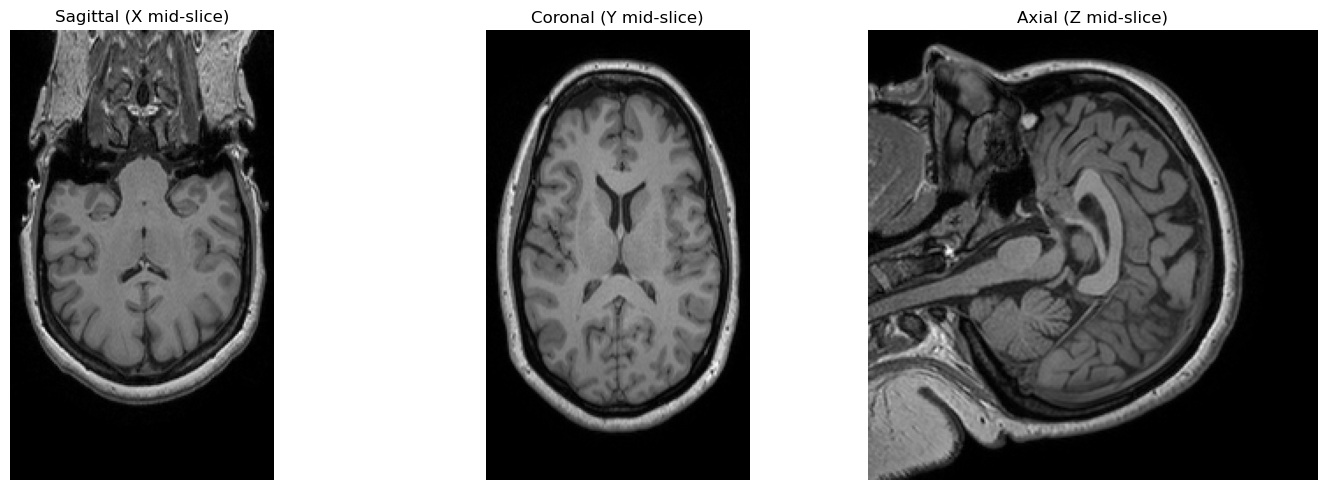

In [27]:
def show_slices(volume):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(volume[volume.shape[0] // 2, :, :], cmap="gray")
    axes[0].set_title("Sagittal (X mid-slice)")
    
    axes[1].imshow(volume[:, volume.shape[1] // 2, :], cmap="gray")
    axes[1].set_title("Coronal (Y mid-slice)")
    
    axes[2].imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")
    axes[2].set_title("Axial (Z mid-slice)")
    
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_slices(volume)

# Normalize Intensities
MRI voxel values vary wildly. Normalize them to [0, 1] or standardize.

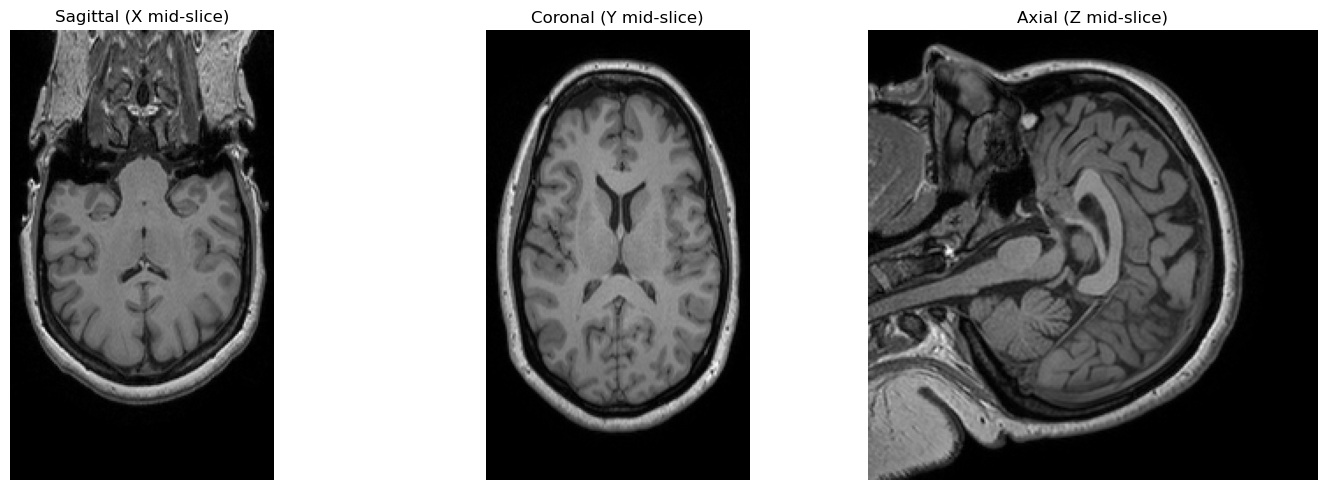

In [28]:
def normalize_volume(vol):
    vol = vol.astype(np.float32)
    vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol))
    return vol

volume_norm = normalize_volume(volume)
show_slices(volume_norm)

# Visualize All Slices as a GIF

In [29]:
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

gif_path = "mri_slices.gif"
images = []

for i in tqdm(range(volume.shape[2])):
    fig, ax = plt.subplots()
    canvas = FigureCanvas(fig)  # Attach canvas
    ax.imshow(volume[:, :, i], cmap="gray")
    ax.axis('off')

    canvas.draw()
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # RGBA
    images.append(image)
    plt.close(fig)

imageio.mimsave(gif_path, images, fps=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 87.74it/s]


# Look at Histogram of Intensities

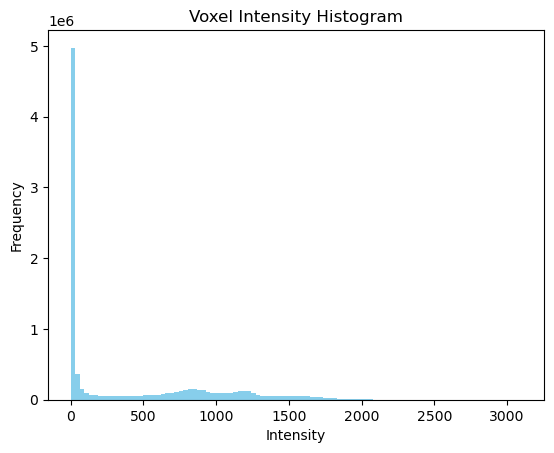

In [30]:
plt.hist(volume.ravel(), bins=100, color='skyblue')
plt.title("Voxel Intensity Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Metadata Extraction

In [31]:
print("Header info:")
print(img.header)

print("\nAffine matrix (voxel to world coordinates):")
print(img.affine)

print("\nVoxel dimensions (mm):", img.header.get_zooms())

Header info:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.93749994  0.93749964  1.1999978   0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MR'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.5557044
quatern_c       : -0.4246065
quatern_d       : -0.5526334
qoffset_x       : -95

# Basic Image Statistics

Volume shape: (256, 256, 150)
Min / Max intensity: 0.0 / 3099.2260694503784
Mean intensity: 415.742730070028


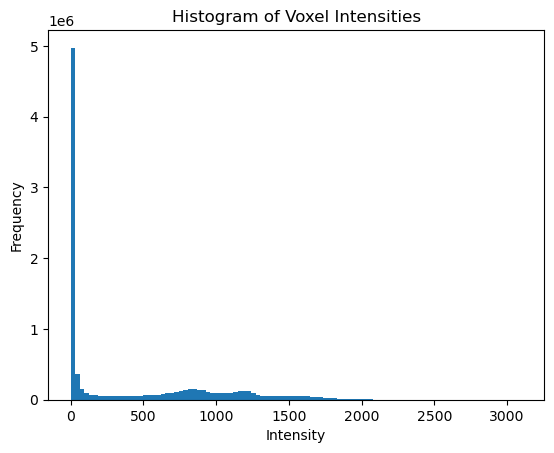

In [32]:
print("Volume shape:", volume.shape)
print("Min / Max intensity:", volume.min(), "/", volume.max())
print("Mean intensity:", volume.mean())

plt.hist(volume.ravel(), bins=100)
plt.title("Histogram of Voxel Intensities")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Noise Simulation

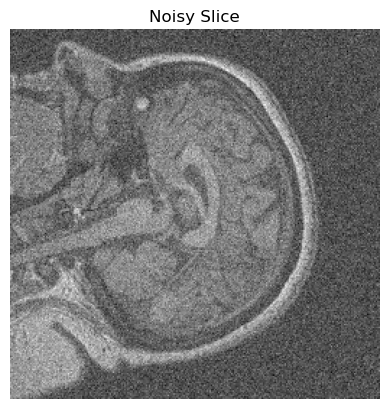

In [33]:
import numpy as np

noisy_volume = volume_norm + 0.1 * np.random.randn(*volume_norm.shape)

plt.imshow(noisy_volume[:, :, noisy_volume.shape[2] // 2], cmap="gray")
plt.title("Noisy Slice")
plt.axis("off")
plt.show()

In [35]:
# 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

# Assume 'volume' is your normalized 3D MRI numpy array
# Threshold determines what surface you're extracting (e.g., brain surface)
threshold = 0.5  # Tune this depending on your data range
verts, faces, normals, values = measure.marching_cubes(volume, level=threshold)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a mesh
mesh = Poly3DCollection(verts[faces], alpha=0.1)
mesh.set_facecolor('cyan')

ax.add_collection3d(mesh)

# Set plot limits
ax.set_xlim(0, volume.shape[0])
ax.set_ylim(0, volume.shape[1])
ax.set_zlim(0, volume.shape[2])

ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
plt.title("3D Surface from MRI Volume")
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'skimage'

In [37]:
!pip install skimage

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
